In [2]:
# make sure you're logged in with \`huggingface-cli login\`
from diffusers import StableDiffusionParticlePipeline, LMSDiscreteScheduler, DDIMScheduler, DDPMScheduler, SDEScheduler, EulerDiscreteScheduler
import torch
import argparse
import os
from torchvision.utils import make_grid, save_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load SD-1.5

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

pipe = StableDiffusionParticlePipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading pipeline class <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_particle.StableDiffusionParticlePipeline'> from /data/scratch/ylxu/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9
config_dict {'_class_name': 'StableDiffusionPipeline', '_diffusers_version': '0.6.0', 'feature_extractor': ['transformers', 'CLIPImageProcessor'], 'safety_checker': ['stable_diffusion', 'StableDiffusionSafetyChecker'], 'scheduler': ['diffusers', 'PNDMScheduler'], 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer'], 'unet': ['diffusers', 'UNet2DConditionModel'], 'vae': ['diffusers', 'AutoencoderKL']}


# Define the prompt

In [4]:
prompt = ['VAN GOGH CAFE TERASSE copy.jpg']

In [5]:
seed = 6
num_of_image = 4
prompt = prompt * num_of_image
# number of sampling steps
steps = 30
# guidance scale
w = 8 


# Vanilla (i.i.d. sampling)

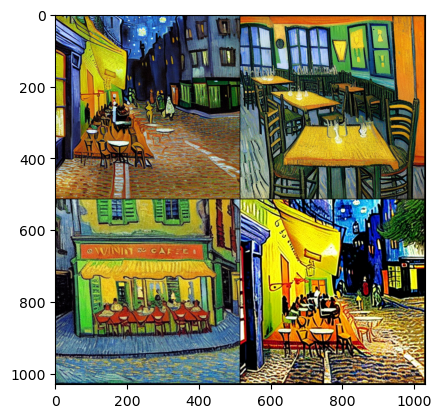

In [6]:
generator = torch.Generator(device="cuda").manual_seed(seed)

out = pipe(prompt, generator=generator, num_inference_steps=steps, guidance_scale=w, output_type='tensor')
image = out.images
image_grid = make_grid(torch.from_numpy(image).permute(0, 3, 1, 2), nrow=int(np.sqrt(len(image))))
plt.imshow(image_grid.permute(1, 2, 0))

del out
torch.cuda.empty_cache()

# Particle Guidance (pixel)

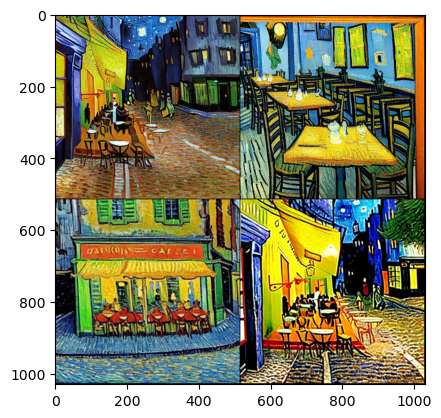

In [7]:
generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale
coeff = 30
out = pipe(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, output_type='tensor')
image = out.images
image_grid = make_grid(torch.from_numpy(image).permute(0, 3, 1, 2), nrow=int(np.sqrt(len(image))))
plt.imshow(image_grid.permute(1, 2, 0))

del out
torch.cuda.empty_cache()

# Particle Guidance (dino feature space)

In [8]:
# load dino 
dino = torch.hub.load('facebookresearch/dino:main', 'dino_vits16').to("cuda")

Using cache found in /data/scratch/ylxu/.cache/torch/hub/facebookresearch_dino_main


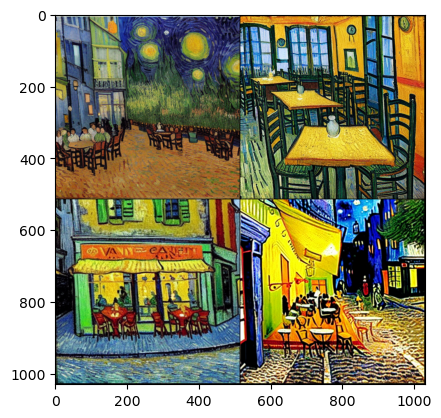

In [10]:
generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale
coeff = 8
out = pipe.dino(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, output_type='tensor')
image = out.images
image_grid = make_grid(torch.from_numpy(image).permute(0, 3, 1, 2), nrow=int(np.sqrt(len(image))))
plt.imshow(image_grid.permute(1, 2, 0))

del out
torch.cuda.empty_cache()